## Auto Encoder 잠재변수 분석
- 잠재변수(작은 차원에 압축된 표현, = z, latent variable)
    - 잠재변수(latent varaiable)를 기준으로 앞부분이 인코더, 뒷부분이 디코더

In [5]:
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

# 오토인코더 생성하는 이미지 관찰을 위한 matplotlib, numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼 파라미터
epochs = 3
batch_size = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

## 오토인코더 모듈 정의

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # self.encoder, self.decoder 정의 및 nn.sequential()을 이용한 묶기
        # encoder - FC-FC-FC
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # 3개여의 특징만 남긴다. (입력의 특징을 3차원 압축)
        )
        
        # decoder - FC-FC-FC 채널 역순
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), # 3개여의 특징만 남긴다.
            nn.Sigmoid(), # 마지막 출력값을 0~1사이로 만들어주는 nn.Sigmoid() 함수가 더해진 것
        )
        
    # Forward
    def forward(self, x):
        encoded = self.encoder(x) # encoder 생성
        decoded = self.decoder(encoded) # encoder 바탕으로 decoder 

        return encoded, decoded # 복원 이미지
    
# 학습 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    # step 마다 train_loader 에서 데이터를 불러옴.
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE) # 입력값도 X 
        y = x.view(-1, 28*28).to(DEVICE) # 결과값도 X
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        # loss 계산, 미분 및 역전파, 반복
        loss = criterion(decoded, y)
        optimizer.zero_grad() # 오차에 대해 미분
        loss.backward() # 역전파 진행
        optimizer.step() # 
        

# 모델 옵션 설정 및 학습
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005) # 최적화 모듈 Adam
criterion = nn.MSELoss() # 두 행렬간의 차이제곱


Using Device: cpu


## 잠재변수를 3D 플롯으로 시각화

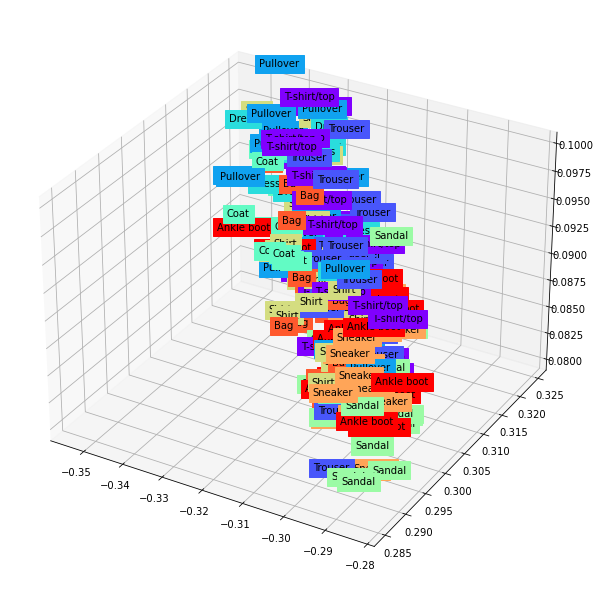

In [8]:
# 잠재변수를 3D 플롯으로 시각화

# test할 데이터 추출
view_data = trainset.data[:200].view(-1, 28*28) # 200장 28,28 이미지
view_data = view_data.type(torch.FloatTensor)/255.

test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x) # autoencoder 거쳐서 나오게 하기
encoded_data = encoded_data.to("cpu")

# Fashion MNIST Classes
CLASSES = {
    0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'
}


# Axes3D를 통한 3차원 액자만들기
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig) 

# 하나의 이미지를 X,Y,Z로 분리
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy() 
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

## 얻을 수 있는 Insight
- 같은 레이블을 가진 이미지의 잠재 변수는 확연히 서로 모인다
- 티셔츠, 드레스, 코트, 셔츠와 같은 윗옷들 끼리는 가깝거나 겹치고,
- 신발류인 앵클부츠, 샌들, 운동화 끼리도 서로 가까이 자리함
- **비슷한 의미를 가진 이미지는 공간적으로 더 가깝다는 것**